# ABM Results

ipynb interface of agent-based modelling results. This file uses the new hdf5 compressed storage of abm results

First import relevant packages

In [141]:
import seaborn as sns
sns.set('talk')
sns.set_style('ticks')


import glob
import numpy as np
import networkx as nx
import datetime
from itertools import count
import tqdm
from typing import NamedTuple
import h5py

import re
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('precision', 2)

import sys

sys.path.append( '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/src/d04_modelling' )

from abm import *
from abm_eval import *
from abm_history_eval import *

#load in search hashtags
with open('../references/search_hashtags.txt', 'r') as f:
    search_hashtags = f.readlines()
    search_hashtags = [i.replace('\n', '') for i in search_hashtags]
    search_hashtags = [i.replace('#', '') for i in search_hashtags]
    search_hashtags = [i.lower() for i in search_hashtags]
    search_hashtags.remove('وأناكمان')

# Checking out which parameter sets are best from data eval tasks - 19/07/2022

In [142]:
results_dir = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/results'
group_num = 2

theoretical_df_loc = f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/results/0{group_num}_group/abm_theoretical_eval_df.obj'
data_df_loc = f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/results/0{group_num}_group/abm_data_eval_df.obj'

with open(theoretical_df_loc, 'rb') as f:
    abm_theo_df = pickle.load(f)

with open(data_df_loc, 'rb') as f:
    abm_data_df = pickle.load(f)

In [94]:
abm_data_df.columns

Index(['experimentation_chance', 'initial_activity_threshold', 'interact_prob',
       'interact_prob_multiplier', 'interact_threshold', 'model_num',
       'peak_delta_init', 'search_hashtag_propensity', 'top_rank_eval',
       'top_by_far_eval', 'rank_eval', 'percent_eval'],
      dtype='object')

In [143]:
abm_data_df.sort_values('percent_eval', ascending=True)

,experimentation_chance,initial_activity_threshold,interact_prob,interact_prob_multiplier,interact_threshold,model_num,peak_delta_init,search_hashtag_propensity,top_rank_eval,top_by_far_eval,rank_eval,percent_eval
12521,3.00e-01,3.0,0.5,1.0,4.0,5.0,7.0,0.2,10.0,-5.01,0.8,15.34
10001,2.00e-01,3.0,0.5,1.1,4.0,5.0,7.0,0.2,10.0,-4.72,0.8,16.24
7480,1.00e-01,3.0,0.5,1.2,4.0,5.0,7.0,0.1,10.0,-4.78,0.8,16.50
12517,3.00e-01,3.0,0.5,1.0,4.0,5.0,3.0,0.2,10.0,-5.89,0.8,16.50
7477,1.00e-01,3.0,0.5,1.2,4.0,5.0,3.0,0.2,10.0,-5.35,0.8,16.60
...,...,...,...,...,...,...,...,...,...,...,...,...
5988,1.00e-01,1.0,0.9,1.2,1.0,6.0,3.0,0.1,10.0,-11.16,0.6,606.29
804,1.00e-02,1.0,0.9,1.2,1.0,6.0,3.0,0.1,10.0,-12.04,0.6,609.92
5989,1.00e-01,1.0,0.9,1.2,1.0,6.0,3.0,0.2,10.0,-11.40,0.6,610.77
8581,2.00e-01,1.0,0.9,1.2,1.0,6.0,3.0,0.2,10.0,-10.91,0.6,611.37


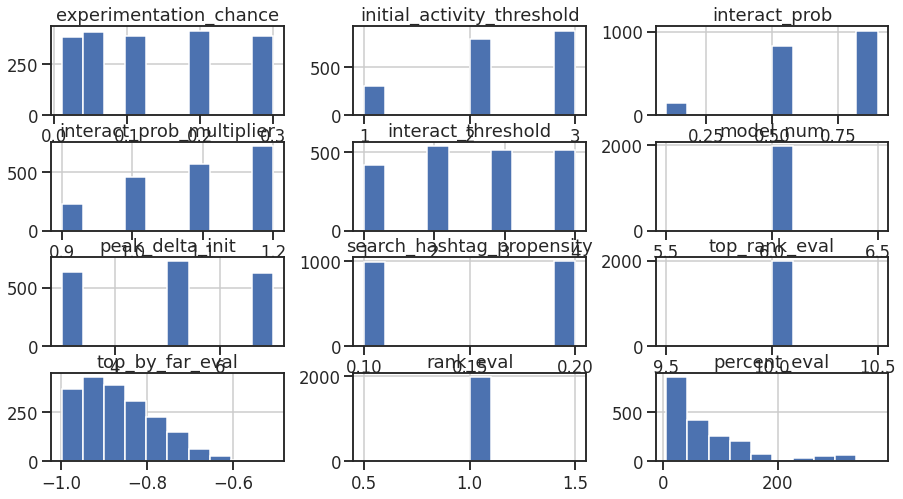

In [136]:
x = abm_data_df[abm_data_df['top_by_far_eval']>-1]
ax = x.iloc[:,].hist(figsize=(15,8))

# Evaluating Fit

parameters searched:


{
    "interact_threshold": [1,2,3,4],
    "initial_activity_threshold": [1,2,3],
    "peak_delta_init": [3,5,7],
    "model_num": [4,5,6],
    "interact_prob": [0.1,0.5,0.9],
    "interact_prob_multiplier": [0.9,1.0,1.1,1.2],
    "experimentation_chance": [0.01,0.05,0.1,0.2,0.3],
    "search_hashtag_propensity": [0.1,0.2],
    "repeat":10
}

In [3]:
# define reference result function appropriate for application here without args.

def reference_results(most_prominent_peaks, group_date_range, group_num, agent_list, activity_file = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/03_processed/activity_counts.hdf5'):
    act_val = {}
    with h5py.File(activity_file, 'r') as f:
        activity_base = f[f'group_{group_num}']
        feature_order = f[f'group_{group_num}'][agent_list[0]]['hashtagged'].attrs['feature_order']
        feature_order = feature_order.split(';')

        for user_id in agent_list:
            # obtain user activity
            act_val[user_id] = {}
            activity = activity_base[user_id]['hashtagged'][:]

            # act_val[user_id] = np.sum(activity[:,-int(daterange_length/2):])

            for hashtag_in_period in most_prominent_peaks:
                hashtag_in_period_index = feature_order.index(hashtag_in_period)

                # obtain the index offset from the detected peak of the hashtag to collect initial time window.
                peak_index_index = (datetime.datetime.strptime(group_date_range.end, '%Y-%m-%d')-most_prominent_peaks[hashtag_in_period]).days
                # offset_index -= peak_delta_init
                # offset_index = max(0,offset_index)+1
                # print(f'Offset for {hashtag_in_period} is {offset_index}')

                act_val[user_id][hashtag_in_period_index]= np.sum(activity[hashtag_in_period_index,-peak_index_index-1:])

    act_val = pd.DataFrame.from_dict(act_val, orient='index').reset_index()
    act_val.columns = ['user_id'] + list(most_prominent_peaks.keys())

    return act_val

def group_peaks_and_daterange(peak_analysis_file, group_num):

    #obtain peak times again
    with h5py.File(peak_analysis_file, 'r') as f:
        FAS_peaks = f['peak_detections']
        x = f['segments']['selected_ranges'][int(group_num)-1]
        group_date_range = daterange(
            start = x[0].decode(),
            end = x[1].decode()
        )

        # group_start_index = reverse_unit_conv(group_date_range.start)
        # group_end_index = reverse_unit_conv(group_date_range.end)

        most_prominent_peaks = {}
        for name, h5obj in FAS_peaks.items():

            peak_locations = h5obj['peak_locations']
            peak_locations = [(i,e) for i,e in enumerate(h5obj['peak_locations']) if (unit_conv(e) > datetime.datetime.strptime(group_date_range.start, '%Y-%m-%d')) and (unit_conv(e) < datetime.datetime.strptime(group_date_range.end, '%Y-%m-%d'))]
            peak_indices = [i[0] for i in peak_locations]
            prominences = [element for index, element in enumerate(h5obj['prominences']) if index in peak_indices]
            if len(prominences) == 0:
                continue
            max_prominence = np.argmax(prominences)
            most_prominent_peaks[name] = unit_conv(peak_locations[max_prominence][1])

    daterange_length = (datetime.datetime.strptime(group_date_range.end, '%Y-%m-%d') - datetime.datetime.strptime(group_date_range.start, '%Y-%m-%d')).days

    return most_prominent_peaks, group_date_range, daterange_length

In [4]:
# set group number
group_num = 2
abm_results_path = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/06_reporting'

# collect group information
most_prominent_peaks, group_date_range, daterange_length = group_peaks_and_daterange('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/02_intermediate/FAS_peak_analysis.hdf5', group_num)

# compressed hdf5 file consolidation:
hdf5_consolidated_file = os.path.join(abm_results_path, f'ABM_output_consolidated_group_{group_num}.hdf5')

# extract params and results and key order, converting it back into a list
with h5py.File(hdf5_consolidated_file, 'r') as f:
    results = f['result'][:]
    key_order = f['result'].attrs['key_order'].strip('[]').replace("'",'').split(', ')
    params = f['params'][:]

# dummy file ref. This is just for collecting agent order.
hdf5_res_file_dummy = os.path.join(abm_results_path, f'0{group_num}_group/ABM_output_group_{group_num}_batch_0.hdf5')

# collect agent order
with h5py.File(hdf5_res_file_dummy, 'r') as f:
    agents = f['agent_order'][:]

# extract reference values
reference_values = reference_results(
    most_prominent_peaks,
    group_date_range,
    group_num,
    agents
)

# for graph visualisations later, load in respective graph object.
graph_savepath = os.path.join(abm_results_path, f'ABM_graph_group_{group_num}.obj')

if os.path.isfile(graph_savepath):
    with open(graph_savepath, 'rb') as f:
        G = pickle.load(f)

In [29]:
with h5py.File(hdf5_consolidated_file, 'r') as f:
    results = f['result'][:]
    key_order = f['result'].attrs['key_order'].strip('[]').replace("'",'').split(', ')
    params = f['params'][:]
    param_order = f['params'].attrs['param_order']

## Evaluation by Theoretical Tests

Tests relating to the theoretical expectations:
 
1. Awareness: do people talk to each other?
    * This can be tested perhaps with whether people do actually communicate across hashtags with their follow networks. Big caveat with the follower networks in the conclusion
2. Experimentation: do people who have interacted meaningfully with another group’s hashtag try their new hashtags?
3. Application: do the new hashtags spread to other people?
 
Tests relating to the data:

1. Is the top hashtag #MeToo?
2. Is it the top hashtag by far?
3. Is the set of the 2nd-3rd or 2nd-5th top hashtags the same?
4. Influence matrix: for every community, take the top 5 communities that influence that community, and take the set intersection between model and data. Average it all up.
 
…something like that. Each one of those needs to be defined more rigorously, and then for every model, these tests will make up a “marks sheet” for us to see if models do or do not pass the test. Also, we spoke about using the best out of 10 runs for every parameter set, since that represents what that parameter set CAN DO.

### 1. Awareness: do people talk to each other?

In [ ]:
# need history logging for this

#compare with history logging
with open('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/06_reporting/ABM_output_group_2_batch_0_history.obj','rb') as f:
    history_edges = pickle.load(f)

def yield_edge_list(history_edges_list):

    # N.B. Interaction_Record namedtuple allows accessing values with attribute method
    for i in history_edges_list:
        if i.interact_result:
            yield (i.source, i.target)

def extract_directions(graph):
    output = nx.DiGraph()
    for i in tqdm.tqdm(graph.edges(data=True)):
        subject_id = G.nodes(data=True)[i[0]]['primary_ht']
        object_id  = G.nodes(data=True)[i[1]]['primary_ht']
        if output.has_edge(subject_id, object_id):
            # we added this one before, just increase the weight by one
            output[subject_id][object_id]['weight'] += 1
        else:
            # new edge. add with weight=1
            output.add_edge(subject_id, object_id, weight=1)
        # output.add_edge(G.nodes(data=True)[i[0]]['primary_ht'], G.nodes(data=True)[i[1]]['primary_ht'])
    return output

history = nx.DiGraph(yield_edge_list(history_edges[0][1]))

# this is for influence matrix
# h_graph = extract_directions(history)
# h_graph.remove_edges_from(nx.selfloop_edges(h_graph))

In [ ]:
# alternative: check follows network? but that's not really the abm itself.

In [ ]:
# for new graph object history thing:
# object is a list of tuples, each tuple is a set of parameters and then the graph of history edges with data parameters.
with open('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/06_reporting/ABM_output_group_2_batch_0_history.obj','rb') as f:
    history_graph_list = pickle.load(f)

# function to process history graph:
def score_graph(history_graph, kind='awareness'):

    if kind=='awareness':
        # if kind is awareness then check the interactions between agents of different primary hashtags

        history_graph.nodes(data=True)

        

In [ ]:
# load in history evaluation objects:
with open(f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/06_reporting/ABM_history_eval_group_{group_num}.obj', 'rb') as f:
    history_eval_obj = pickle.load(f)

In [ ]:
history_eval_obj[]

### 2. Experimentation: do people who have interacted meaningfully with another group's hashtag try their new hashtags?

In [ ]:
# check whether experimentation occurs to help spread

### 3. Application: do new hashtags spread to other people?

That is, do people who have received L1 from someone then spread it to another person L3?

## Evaluation by data:

### 1. Is the top hashtag #MeToo

In [ ]:
# use score function below

### 2. Is it the top hashtag by far?

### 3. is the set of 2-3 and 2-5th hashtags the same?

### 4. Influence matrix

## Evaluation by basic distance to data

In [19]:
def score(result_np_array, key_order, params, reference_values, kind = 'percentage', avg=True):


    '''
    Function: process an np array of consolidated results to a score for each parameter combination. This can be by the average results of each combination, or the best one.
    '''

    # TO CHANGE LATER: REMOVE 0 VALUES
    reference_df = reference_values[reference_values['actual']>0]

    # sort refernece df
    reference_df = reference_df.sort_values(by='actual', ascending=False)

    # np.unique returns the unique values in an array and can return their indices to reconstruct the original array.
    unq, indices= np.unique(params, axis=0, return_inverse=True)

    # indices of hashtags needed for this group
    x = np.array([np.where(np.array(key_order)==x)[0][0] for x in reference_df['index']])
    print(reference_df['index'])
    print(x)

    # use these unique incides to extract the desired processed result
    # result_np_array_processed = np.zeros(shape = (len(unq), len(x)))

    # filter down necessary results to just those found in the line before
    result_np_array_processed = result_np_array[:,x]
    # print(result_np_array_processed.shape)
    # print(reference_df['actual'].shape)
    # print((result_np_array_processed-np.array(reference_df['actual'])).shape)

    # create output array
    evaluated = np.zeros(len(unq))

    if avg:

        if kind == 'percentage':

            # calc percentages
            result_np_array_processed = np.abs((result_np_array_processed-np.array(reference_df['actual']))/np.array(reference_df['actual']))

            # assign appropriate value in output array
            for i in range(len(unq)):
                evaluated[i] = result_np_array_processed[indices==i].sum().mean()

    else:

        if kind == 'percentage':

            # calc percentages
            result_np_array_processed = np.abs((result_np_array_processed-np.array(reference_df['actual']))/np.array(reference_df['actual']))

            # assign appropriate value in output array
            for i in range(len(unq)):
                evaluated[i] = result_np_array_processed[indices==i].sum().min()

        elif kind == 'rank':

            # assign score to each rank depending on its distance with actual ranking. Ideal (i.e. matching all ranks) is a 0 score.
            rank_array_sorted = np.argsort(result_np_array_processed, axis=1)[:,::-1]
            rank_array_temp = (np.abs(rank_array_sorted - np.arange(len(x)))).sum(axis=1)
            # print(np.argsort(result_np_array_processed, axis=1).shape)
            # print(rank_array_temp.shape)

            for i in range(len(unq)):
                evaluated[i] = rank_array_temp[indices==i].min()

        elif kind == 'top_rank':

            # assign score to each rank depending on its distance with actual ranking. Only keep top rank.
            rank_array_sorted = np.argsort(result_np_array_processed, axis=1)[:,::-1]
            rank_array_top_check = rank_array_sorted[:,0]==0

            for i in range(len(unq)):
                evaluated[i] = rank_array_top_check[indices==i].sum()

    return reference_df['index'], evaluated, unq, indices


In [20]:
act = (reference_values.iloc[:,1:]>2).sum(axis=0).to_frame().reset_index()
act.columns = ['index', 'actual']

In [21]:
evaluated = score(results, key_order, params, act, avg=False, kind='rank')

0         metoo
3    noustoutes
2    niunamenos
1      moiaussi
4         wetoo
Name: index, dtype: object
[ 0 27 24  2 21]


In [24]:
evaluated[3]

array([ 9552,  9553,  9554, ..., 10125, 10126, 10127])

In [12]:
evaluated[1].min()

0.0

In [15]:
len(params)

129600

In [ ]:
np.argmin(evaluated[1])

In [16]:
evaluated[1].shape

(12960,)

In [17]:
params.shape

(129600, 8)

NameError: name 'unq' is not defined

In [ ]:
results[2122]

In [ ]:
sns.boxplot(data=evaluated[1])

## Question 1: Which parameter set gives the 'best fit'?

Not trivial to define 'best fit'! L1 distance, L2 distance? Bayesian inference?

In [ ]:
def process_best_fit(summary, reference_values, how = 'left', subset = None, restrict = {}):

    if isinstance(subset, str):
        subset = [subset]
        print('subset was a string, converted to list')

    if restrict:
        assert isinstance(restrict, dict)

    best_fit = []
    summary_index_list = []
    for summary_index, item in tqdm.tqdm(enumerate(summary), total = len(summary)):
        params, values = item
        stop = False
        for k,v in restrict.items():
            if params[k] != v:
                stop = True
                continue
        if stop:
            continue
        summary_index_list.append(summary_index)
        temp = values.merge(reference_values[1], on='index', how=how).fillna(0)
        # print(temp)
        if subset is not None:
            # print(subset)
            temp = temp[temp['index'].isin(subset)]
            # print(temp)
        best_fit.append(np.sqrt(((temp.iloc[:,2]-temp.iloc[:,1])**2).sum()))
    best_fit = np.array(best_fit)

    return summary_index_list, best_fit

# summary_index_list, best_fit = process_best_fit(summary, reference_values, restrict = {'model_num':5})

In [ ]:
def display_best_results(summary, summary_index_list,best_fit, how = 'left'):
    best_fit_idx = np.argmin(best_fit)
    print(f'Params for best fit:')
    params = summary[summary_index_list[best_fit_idx]][0]
    print(params)

    # display results
    best_fit_results = summary[summary_index_list[best_fit_idx]][1]
    best_fit_results = best_fit_results.merge(reference_values[1], on='index', how=how).fillna(0)
    print(best_fit_results)
    return params, best_fit_results

In [ ]:
how = 'right'
summary_index_list, best_fit = process_best_fit(summary, reference_values, how=how)
_, best_fit_results = display_best_results(summary, summary_index_list, best_fit, how=how)

In [ ]:
best_fit_results['actual'] = best_fit_results['actual'].astype(int)
best_fit_results = best_fit_results.sort_values('actual',ascending=False)
best_fit_results.style.hide_index()

## Question 2: Which model number is best?

In [ ]:
results_by_model = []
how='left'
for model_num in range(1,7):
    summary_index_list, best_fit = process_best_fit(summary, reference_values, how=how,restrict = {'model_num':model_num})
    _, best_fit_results = display_best_results(summary, summary_index_list, best_fit, how=how)
    results_by_model.append((summary_index_list,best_fit, best_fit_results))

In [ ]:
print_df = results_by_model[-2][-1].sort_values(by='actual', ascending=False)
print_df['actual'] = print_df['actual'].astype(int)
print_df.style.hide_index()

## Question 3: Given a best parameter set for each group, what's the variance of these results and t-test with actual results

In [ ]:
arc_repeat_file = os.path.join('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/06_reporting', f'ABM_summary_group_{group_num}_repeat.obj')

with open(arc_repeat_file, 'rb') as f:
    summary_repeat = pickle.load(f)

repeat_results = summary_repeat[0][1][1]
reference_results = summary_repeat[-1]
summary_repeat = summary_repeat[:-1]
summary_repeat = [item for sublist in summary_repeat for item in sublist]

In [ ]:
for i,e in tqdm.tqdm(enumerate(summary_repeat[1:]), total=len(summary_repeat[1:])):

    repeat_results = repeat_results.merge(e[1], on='index', suffixes=(None,f'_{i}'))

In [ ]:
repeat_results['mean'] = repeat_results.filter(regex='^abm',axis=1).mean(axis=1)
repeat_results['var'] = repeat_results.filter(regex='^abm',axis=1).var(axis=1)
repeat_results = repeat_results.merge(reference_results[-1], on='index')
repeat_results['t_stat'] = (repeat_results['actual'] - repeat_results['mean'])/(np.sqrt(repeat_results['var'])/np.sqrt(1000))

In [ ]:
repeat_results[['index','mean','actual']].sort_values(by='mean', ascending=False).style.hide_index()

### What's the primary ht distribution?

In [ ]:
with open('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/03_processed/primary_ht_global.obj', 'rb') as f:
    user_order, pht = pickle.load(f)

user_doc_ids = sorted(glob.glob(os.path.join(f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/01_raw/0{group_num}_group/','timeline*.jsonl')))
user_doc_ids = [re.split('[_.]',i)[-2] for i in user_doc_ids]
assert len(user_doc_ids)>0

In [ ]:
def process_primary_res(author_id):
    global unknown_count
    if author_id not in user_order:
        # print(f'{author_id} not in users')
        unknown_count += 1
        return 'metoo'
    return search_hashtags[np.argmax(res[user_order.index(author_id),:])]

pt_dist = {k: 0 for k in search_hashtags}
pt_users = {}
for i in user_doc_ids:
    try:
        primary_ht = search_hashtags[np.argmax(pht[user_order.index(i),:])]
        pt_dist[primary_ht] += 1
        pt_users[i] = primary_ht
    except:
        pass

In [ ]:
pt_dist

### Plot distribution of fit numbers

In [ ]:
sns.boxplot(data = best_fit)

In [ ]:
def find_result_with_params(query, summary):

    # function to find, given a set of parameters, the results of that parameter set.

    for params, result in summary:
        if params == query:
            print('Result found. returning...')
            return result
    print('No result found. Ending. Check query')
    return None

searched_res = find_result_with_params({
   'experimentation_chance': 0.3,
 'initial_activity_threshold': 1,
 'interact_prob': 0.9,
 'interact_prob_multiplier': 1.1,
 'interact_threshold': 2,
 'model_num': 5,
 'peak_delta_init': 5,
 'search_hashtag_propensity': 0.2
},summary)

In [ ]:
searched_res

In [ ]:
summary

### Is there graph saturation?

In [ ]:
len(G)

In [ ]:
[len(c) for c in sorted(nx.connected_components(G.to_undirected()), key=len, reverse=True)][0]

# connected component for group 1 is basically the whole graph so nope.

In [ ]:
G.nodes['1000012910']

In [ ]:
G.nodes()[list(G.nodes())[0]]

In [ ]:
# drawing the full graph is time consuming and probably not informative. Check out subgraphs.

# subgraph by node attribute
# create generator
nodes = (
    node
    for node, data
    in G.nodes(data=True)
    if data.get("primary_ht") == "niunamenos" or data.get("primary_ht") == "noustoutes" 
)
H = G.subgraph(nodes)

In [ ]:
ancestors = set()
for node in tqdm.tqdm(H.nodes()):
    ancestors.update(nx.ancestors(G,node))

In [ ]:
len(ancestors)

In [ ]:
# create number for each group to allow use of colormap
# get unique groups
from itertools import count
groups = set(nx.get_node_attributes(H,'primary_ht').values())
mapping = dict(zip(sorted(groups),count()))
nodes = H.nodes()
colors = [mapping[H.nodes[n]['primary_ht']] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(H)
ec = nx.draw_networkx_edges(H, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(H, pos, nodelist=nodes, node_color=colors, node_size=100, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

### Can we see any network effects? Do we reproduce meso-level leadership/brokerage?

In [ ]:
# to do this, maybe create network from history logging and then we can see if users with high centrality also had high activity? But how to measure more than usual?

bc = nx.betweenness_centrality(G)

In [ ]:
max(bc.values())

## Directionality: RQ2 on different diffusive directions

In [ ]:
def extract_directions(graph):
    output = nx.DiGraph()
    for i in tqdm.tqdm(graph.edges(data=True)):
        subject_id = G.nodes(data=True)[i[0]]['primary_ht']
        object_id  = G.nodes(data=True)[i[1]]['primary_ht']
        if output.has_edge(subject_id, object_id):
            # we added this one before, just increase the weight by one
            output[subject_id][object_id]['weight'] += 1
        else:
            # new edge. add with weight=1
            output.add_edge(subject_id, object_id, weight=1)
        # output.add_edge(G.nodes(data=True)[i[0]]['primary_ht'], G.nodes(data=True)[i[1]]['primary_ht'])
    return output

In [ ]:
d_graph = extract_directions(G)
d_graph.remove_edges_from(nx.selfloop_edges(d_graph))

In [ ]:
search_hashtags

In [ ]:
#define font families to use
import matplotlib
mono_font = {'fontname':'monospace'}
serif_font = {'fontname':'serif'}
matplotlib.rcParams['font.family'] = 'monospace'
degree_dict = dict(d_graph.out_degree)
nx.draw(d_graph, 
    with_labels=True,
    node_size = [v * 100 for v in degree_dict.values()],
    pos=nx.spring_layout(d_graph, k=20)
    )

In [ ]:
# fixing the size of the figure
plt.figure(figsize =(15, 10))
  
node_color = [d_graph.out_degree(v) for v in d_graph]
# node colour is a list of degrees of nodes
  
# node_size = [0.0005 * nx.get_node_attributes(d_graph, 'population')[v] for v in d_graph]
# size of node is a list of population of cities
  
edge_width = [0.0005 * d_graph[u][v]['weight'] for u, v in d_graph.edges()]
# width of edge is a list of weight of edges
  
nx.draw_networkx(d_graph,
                 pos = nx.spring_layout(d_graph, k=20),
                 node_color = node_color,
                 with_labels = True,
                #  width = edge_width,
                 node_size = [v * 500 for v in degree_dict.values()],
                 cmap = plt.cm.Blues,
                 font_size = 20)

plt.axis('off')
plt.tight_layout();
plt.savefig(f'../results/0{group_num}_group/original_graph.png', transparent=True, bbox_inches='tight')

In [ ]:
#compare with history logging
with open('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/06_reporting/ABM_output_group_2_batch_0_history.obj','rb') as f:
    history_edges = pickle.load(f)

In [ ]:
def yield_edge_list(history_edges_list):

    for i in history_edges_list:
        if i.interact_result:
            yield (i.source, i.target)

In [ ]:
history = nx.DiGraph(yield_edge_list(history_edges[0][1]))

In [ ]:
h_graph = extract_directions(history)
h_graph.remove_edges_from(nx.selfloop_edges(h_graph))

In [ ]:
# fixing the size of the figure
plt.figure(figsize =(15, 10))
  
node_color = [h_graph.out_degree(v) for v in h_graph]
# node colour is a list of degrees of nodes
  

degree_dict = dict(h_graph.out_degree)
# node_size = [0.0005 * nx.get_node_attributes(d_graph, 'population')[v] for v in d_graph]
# size of node is a list of population of cities
  
edge_width = [0.0005 * h_graph[u][v]['weight'] for u, v in h_graph.edges()]
# width of edge is a list of weight of edges
  
nx.draw_networkx(h_graph,
                 pos = nx.spring_layout(h_graph, k=20),
                 node_color = node_color,
                 with_labels = True,
                #  width = edge_width,
                 node_size = [v * 500 for v in degree_dict.values()],
                 cmap = plt.cm.Blues,
                 font_size = 20)

plt.axis('off')
plt.tight_layout();
plt.savefig(f'../results/0{group_num}_group/history_graph.png', transparent=True, bbox_inches='tight')

## Visualisation: network growing with ABM?

## Tell a story. How did these networks develop? Were particular agents more improtant and in what languages?

# To examine on specific paramter combination

In [ ]:
group_num = 3
results_file = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/06_reporting/ABM_output_group_2.obj'

activity_file = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/03_processed/activity_counts.hdf5'

peak_analysis_file = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/02_intermediate/FAS_peak_analysis.hdf5'

most_prominent_peaks, group_date_range, daterange_length = group_peaks_and_daterange(peak_analysis_file, group_num)

with open(results_file, 'rb') as f:
    raw_results = pickle.load(f)

In [ ]:
group_date_range

each entry is a tuple of the configurations given and the abm result.

In [ ]:
raw_results[0]

In [ ]:
def print_abm_results(agents_dict, model_num=None):

    output_dict={}

    total = len(agents_dict)
    # num_supporting = 0
    # num_not_supporting = 0

    for user_id, agent in agents_dict.items():
        output_dict[user_id] = agent.supporting_metoo_dict

    output_df = pd.DataFrame.from_dict(output_dict, orient='index').reset_index()

    num_supporting = output_df.iloc[:,1:].sum(axis=0)
    num_supporting = num_supporting[num_supporting>0]
    num_not_supporting = (output_df==False).sum(axis=0)

    # print(num_supporting)
    # print(num_not_supporting)
    return output_df


def reference_results(activity_file, agents, group_num):
    act_val = {}
    for user_id, agent in agents.items():
        # obtain user activity
        act_val[user_id] = {}
        with h5py.File(activity_file, 'r') as f:
            activity = f[f'group_{group_num}'][user_id]['hashtagged'][:]
            feature_order = f[f'group_{group_num}'][user_id]['hashtagged'].attrs['feature_order']
            feature_order = feature_order.split(';')
            # act_val[user_id] = np.sum(activity[:,-int(daterange_length/2):])

            for hashtag_in_period in most_prominent_peaks:
                hashtag_in_period_index = feature_order.index(hashtag_in_period)

                # obtain the index offset from the detected peak of the hashtag to collect initial time window.
                peak_index_index = (datetime.datetime.strptime(group_date_range.end, '%Y-%m-%d')-most_prominent_peaks[hashtag_in_period]).days
                # offset_index -= peak_delta_init
                # offset_index = max(0,offset_index)+1
                # print(f'Offset for {hashtag_in_period} is {offset_index}')

                act_val[user_id][hashtag_in_period_index]= np.sum(activity[hashtag_in_period_index,-peak_index_index-1:])

    act_val = pd.DataFrame.from_dict(act_val, orient='index').reset_index()
    act_val.columns = ['user_id'] + list(most_prominent_peaks.keys())

    return act_val


In [ ]:
act_val = reference_results(activity_file, raw_results[param_grid_num][1], group_num)
act = (act_val.iloc[:,1:]>2).sum(axis=0).to_frame().reset_index()
act.columns = ['index', 'actual']

In [ ]:
param_grid_num = 5

In [ ]:
raw_results[param_grid_num][0]

In [ ]:
res = print_abm_results(raw_results[param_grid_num][1],raw_results[param_grid_num][0]['model_num'])
num_supporting = res.iloc[:,1:].sum(axis=0)
num_supporting = num_supporting[num_supporting>0]
num_supporting = num_supporting.to_frame().reset_index()
num_supporting.columns = ['index', 'abm']

In [ ]:
comparison = act.merge(num_supporting, on='index', how='right').fillna(0)
comparison

# Plotting simulations

In [ ]:
for user in list(raw_results[param_grid_num][1].keys()):
    user_to_examine = raw_results[param_grid_num][1][user]
    if user_to_examine.support_tracker.sum() > 0:
        break

In [ ]:
user_to_examine.probability_matrix


In [ ]:
user_to_examine = raw_results[param_grid_num][1][list(raw_results[param_grid_num][1].keys())[0]]
# usertype = 'low'

class daterange(NamedTuple):
    start: str
    end: str

# obtain user activity
with h5py.File(activity_file, 'r') as f:
    activity = f[f'group_{group_num}'][user_to_examine]['hashtagged'][:]
    feature_order = f[f'group_{group_num}'][user_to_examine]['hashtagged'].attrs['feature_order']
    feature_order = feature_order.split(';')

with h5py.File('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/02_intermediate/FAS_peak_analysis.hdf5', 'r') as f:
    FAS_peaks = f['peak_detections']
    x = f['segments']['selected_ranges'][int(group_num)-1]
    group_date_range = daterange(
        start = x[0].decode(),
        end = x[1].decode()
    )


daterange = pd.date_range(start=group_date_range.start, end=group_date_range.end)
if group_num == 1:
    daterange = pd.date_range(start=group_date_range.start, end='2018-05-30')

plot_user_df = pd.DataFrame({
    'created_at' : daterange})

for index, feature in enumerate(feature_order):
    plot_user_df[f'activity_{feature}'] = activity[index,:]

plot_user_df=pd.wide_to_long(plot_user_df, stubnames='activity', i='created_at', j='ht', sep = '_', suffix='.*').reset_index()

user_df = df[df['author_id']==user_to_examine]
user_df = user_df.groupby(['created_at', 'ht']).count()['tweet_id'].reset_index()
user_df['created_at'] = pd.to_datetime(user_df['created_at'])
final_user_plot_df = user_df.merge(plot_user_df, on = ['created_at','ht'], how='left')
final_user_plot_df.columns = ['created_at', 'Hashtag', 'Interaction Count', 'Hashtag Protest Network Activity']

# final_user_plot_df['interaction_count'] = final_user_plot_df['activity']-final_user_plot_df['tweet_id']
# final_user_plot_df = final_user_plot_df.drop(['tweet_id'])

df[df['author_id']==user_to_examine]

temp = df.groupby(['author_id','ht']).count().reset_index()
temp = temp[['author_id', 'ht']].groupby('author_id').count()
temp[temp['ht']>1]

pd.melt(final_user_plot_df, ['created_at','Hashtag'])

fig = plt.figure(figsize = (16,9))

# Draw line plot of size and total_bill with parameters and hue "day"
sns.lineplot(
    x = "created_at", y = "value", hue='variable',data=pd.melt(final_user_plot_df, ['created_at','Hashtag']))
plt.title("Interactions per day per hashtag", fontsize = 20)
plt.xlabel("Date", fontsize = 15)
plt.ylabel("Interactions", fontsize = 15)
plt.savefig(f'{plot_save_path}user_{usertype}_output_{group_num}.png')
plt.show();